In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import & Set-up

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset
from torchvision import transforms, models
from PIL import Image
import torch.nn.functional as F
import uuid

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

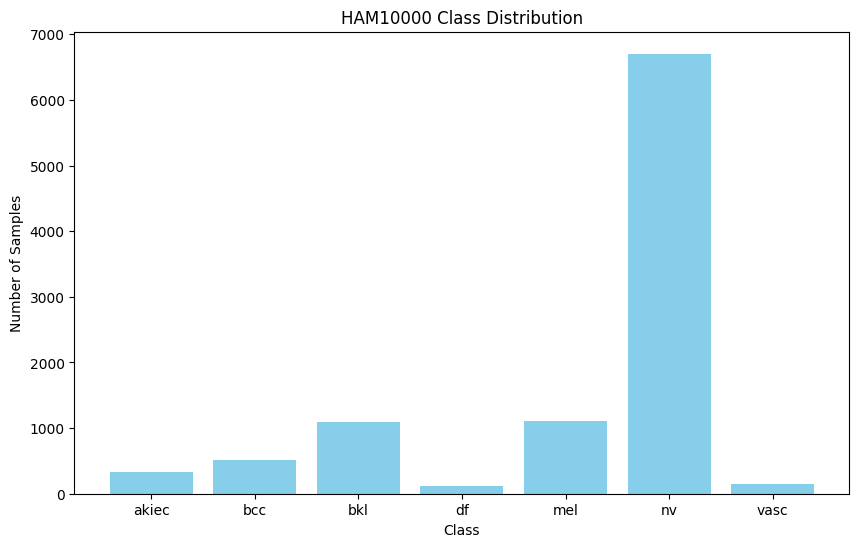

Class counts:
akiec: 327
bcc: 514
bkl: 1099
df: 115
mel: 1113
nv: 6705
vasc: 142


In [7]:
# Ham10000 Dataset initialization

import pandas as pd
import matplotlib.pyplot as plt

# Load metadata
metadata_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
df = pd.read_csv(metadata_path)

# Class distribution
class_counts = df['dx'].value_counts()
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
counts = [class_counts.get(cls, 0) for cls in classes]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.title('HAM10000 Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

print("Class counts:")
for cls, count in zip(classes, counts):
    print(f"{cls}: {count}")

GAN Epoch 1/30, Batch 0/501, D Loss Real: 0.7869, D Loss Fake: 0.5740, G Loss: 0.2676
GAN Epoch 1/30, Batch 100/501, D Loss Real: 0.5149, D Loss Fake: 0.5705, G Loss: 8.7144
GAN Epoch 1/30, Batch 200/501, D Loss Real: 0.4349, D Loss Fake: 0.4290, G Loss: 2.1350
GAN Epoch 1/30, Batch 300/501, D Loss Real: 0.4407, D Loss Fake: 0.4689, G Loss: 4.6503
GAN Epoch 1/30, Batch 400/501, D Loss Real: 0.3852, D Loss Fake: 0.5081, G Loss: 2.6256
GAN Epoch 1/30, Batch 500/501, D Loss Real: 0.7970, D Loss Fake: 0.7524, G Loss: 1.2763
GAN Epoch 2/30, Batch 0/501, D Loss Real: 0.5620, D Loss Fake: 1.0601, G Loss: 5.1279
GAN Epoch 2/30, Batch 100/501, D Loss Real: 0.6070, D Loss Fake: 0.6809, G Loss: 2.9768
GAN Epoch 2/30, Batch 200/501, D Loss Real: 0.4170, D Loss Fake: 0.3855, G Loss: 4.3745
GAN Epoch 2/30, Batch 300/501, D Loss Real: 0.3767, D Loss Fake: 0.4837, G Loss: 2.3649
GAN Epoch 2/30, Batch 400/501, D Loss Real: 0.6769, D Loss Fake: 0.4001, G Loss: 2.7822
GAN Epoch 2/30, Batch 500/501, D Los

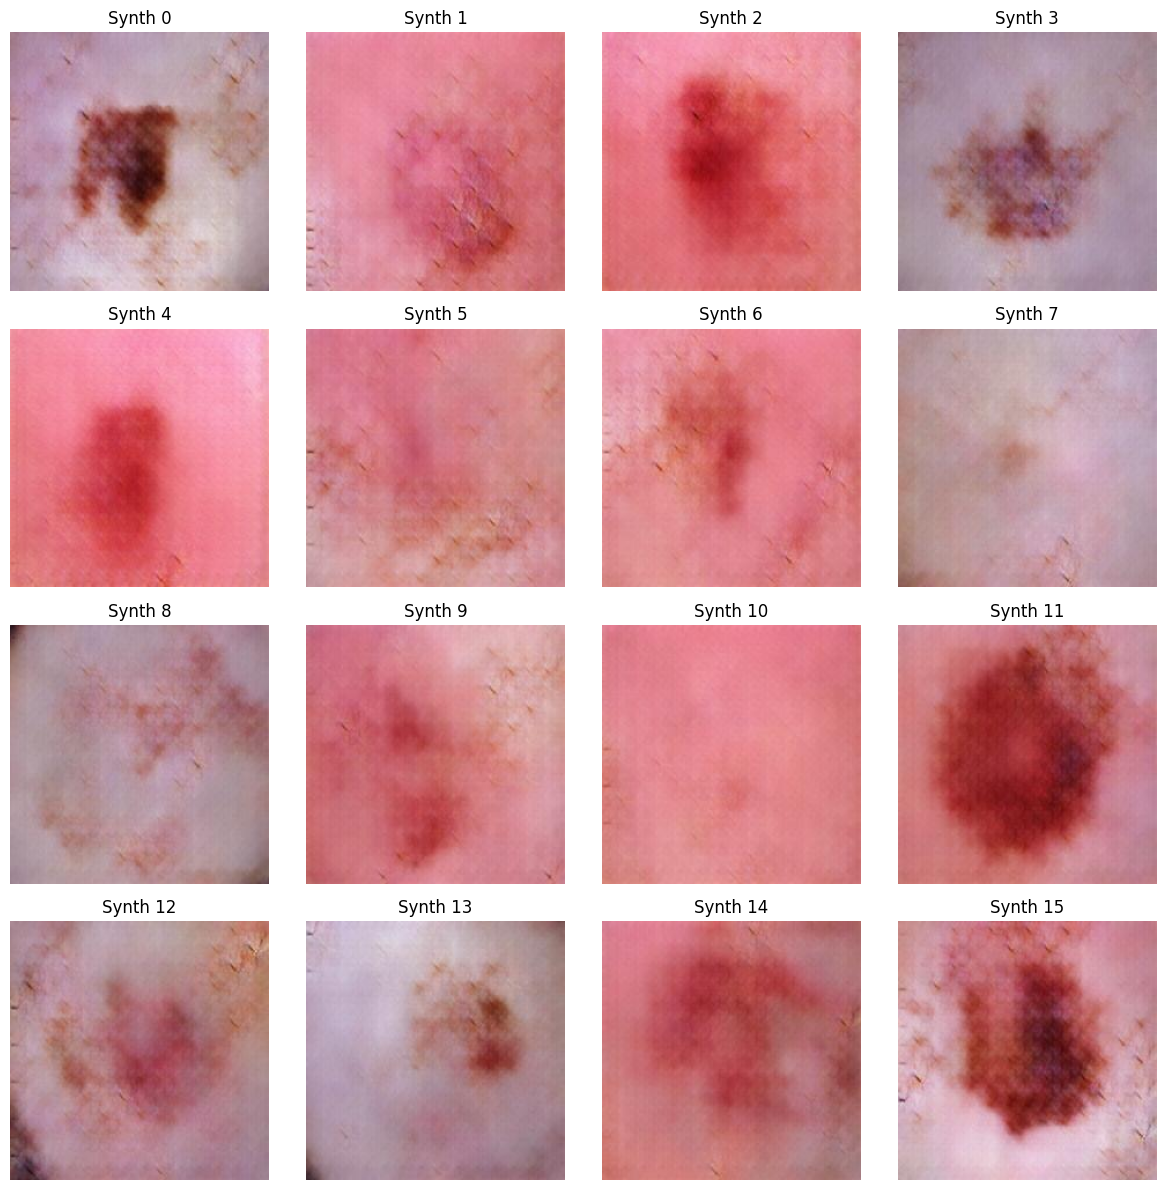

In [8]:
# Gan image generation

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class to index mapping
class_to_idx = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

# Custom HAM10000 Dataset
class HAM10000Dataset(Dataset):
    def __init__(self, metadata_df, image_dir1, image_dir2, synthetic_dir=None, transform=None, is_train=False):
        self.df = metadata_df
        self.image_dir1 = image_dir1
        self.image_dir2 = image_dir2
        self.synthetic_dir = synthetic_dir
        self.transform = transform
        self.is_train = is_train
        
        self.class_to_idx = class_to_idx
        self.classes = list(self.class_to_idx.keys())
        
        self.valid_data = []
        for idx, row in self.df.iterrows():
            image_id = row['image_id']
            if image_id.startswith('synth_') and self.synthetic_dir:
                img_path = os.path.join(self.synthetic_dir, f"{image_id}.jpg")
            else:
                img_path1 = os.path.join(self.image_dir1, f"{image_id}.jpg")
                img_path2 = os.path.join(self.image_dir2, f"{image_id}.jpg")
                img_path = img_path1 if os.path.exists(img_path1) else img_path2
            if os.path.exists(img_path):
                self.valid_data.append((img_path, row['dx']))
    
    def __len__(self):
        return len(self.valid_data)
    
    def __getitem__(self, idx):
        img_path, label = self.valid_data[idx]
        image = Image.open(img_path).convert('RGB')
        label_idx = self.class_to_idx[label]
        
        if self.transform:
            image = self.transform(image)
        return image, label_idx

# GAN Implementation
def train_gan_and_generate(full_dataset, num_synthetic=350, epochs=10, batch_size=4):
    class Generator(nn.Module):
        def __init__(self, latent_dim=100):
            super().__init__()
            self.model = nn.Sequential(
                nn.Linear(latent_dim, 256 * 14 * 14),
                nn.ReLU(),
                nn.Unflatten(1, (256, 14, 14)),
                nn.ConvTranspose2d(256, 128, 4, 2, 1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, 4, 2, 1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 32, 4, 2, 1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 3, 4, 2, 1),
                nn.Tanh()
            )
        
        def forward(self, z):
            return self.model(z)
    
    class Discriminator(nn.Module):
        def __init__(self):
            super().__init__()
            self.model = nn.Sequential(
                nn.Conv2d(3, 64, 4, 2, 1),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Conv2d(64, 128, 4, 2, 1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Conv2d(128, 256, 4, 2, 1),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2),
                nn.Flatten(),
                nn.Linear(256 * 28 * 28, 1),
                nn.Sigmoid()
            )
        
        def forward(self, x):
            return self.model(x)
    
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    
    g_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    
    gan_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    for epoch in range(epochs):
        for batch_idx, (real_images, _) in enumerate(gan_loader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            
            # Discriminator: Real images
            d_optimizer.zero_grad()
            real_output = discriminator(real_images)
            real_labels = torch.full_like(real_output, 0.9)
            d_loss_real = nn.BCELoss()(real_output, real_labels)
            d_loss_real.backward()
            
            # Discriminator: Fake images
            noise = torch.randn(batch_size, 100).to(device)
            fake_images = generator(noise)
            fake_output = discriminator(fake_images.detach())
            fake_labels = torch.full_like(fake_output, 0.1)
            d_loss_fake = nn.BCELoss()(fake_output, fake_labels)
            d_loss_fake.backward()
            d_optimizer.step()
            
            # Generator
            g_optimizer.zero_grad()
            fake_output = discriminator(fake_images)
            g_loss = nn.BCELoss()(fake_output, torch.ones_like(fake_output))
            g_loss.backward()
            g_optimizer.step()
            
            if batch_idx % 100 == 0:
                print(f"GAN Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(gan_loader)}, "
                      f"D Loss Real: {d_loss_real.item():.4f}, D Loss Fake: {d_loss_fake.item():.4f}, G Loss: {g_loss.item():.4f}")
        
        torch.cuda.empty_cache()
    
    noise = torch.randn(num_synthetic, 100).to(device)
    synthetic_images = generator(noise).cpu().detach()
    synthetic_labels = np.random.choice(list(class_to_idx.keys()), num_synthetic)
    synthetic_df = pd.DataFrame({
        'image_id': [f'synth_{i}' for i in range(num_synthetic)],
        'dx': synthetic_labels
    })
    
    synthetic_dir = "/kaggle/working/synthetic_images"
    os.makedirs(synthetic_dir, exist_ok=True)
    for i, img_tensor in enumerate(synthetic_images):
        img_tensor = (img_tensor + 1) / 2
        img = transforms.ToPILImage()(img_tensor)
        img.save(os.path.join(synthetic_dir, f"synth_{i}.jpg"))
    
    # Save synthetic_df as CSV
    synthetic_df.to_csv(os.path.join(synthetic_dir, "synthetic_metadata.csv"), index=False)
    
    # Visualize GAN output
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()
    for i in range(min(16, num_synthetic)):
        img_path = os.path.join(synthetic_dir, f"synth_{i}.jpg")
        img = Image.open(img_path).convert('RGB')
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Synth {i}')
    plt.tight_layout()
    plt.show()
    
    return synthetic_df, synthetic_dir

# Load dataset for GAN
df = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
gan_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
full_dataset = HAM10000Dataset(df, 
                               "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1",
                               "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2",
                               transform=gan_transform)

# Train GAN and visualize output
synthetic_df, synthetic_dir = train_gan_and_generate(full_dataset, num_synthetic=500, epochs=30, batch_size=20)

Minority class identified: bcc, mel, akiec, df and vasc
Augmented dataset contains 10371 images.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


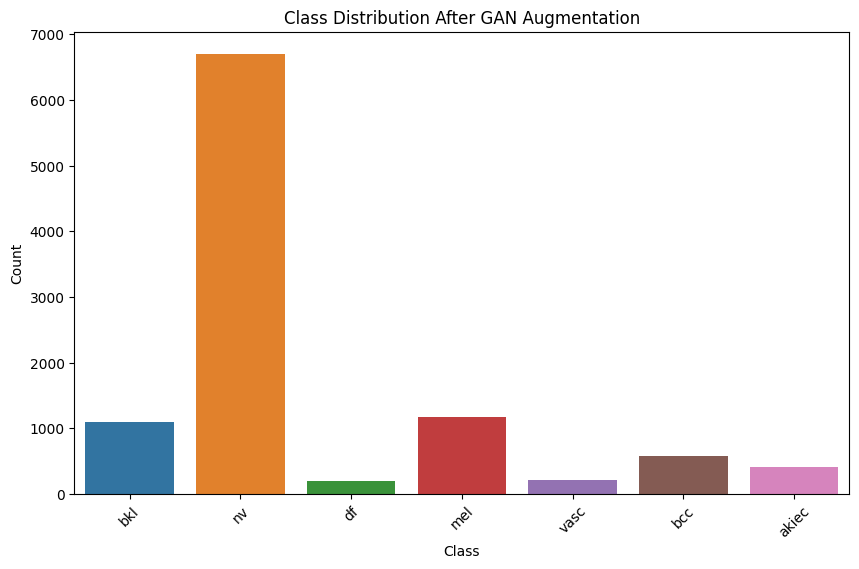

In [9]:
# Augmentation, Synthetic image addition (except nv and bkl)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torchvision import transforms

# === 1. Define Original HAM10000 Dataset Class ===
class HAM10000Dataset(Dataset):
    def __init__(self, metadata, img_dir, transform=None):
        self.data = metadata
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
        self.classes = list(self.class_to_idx.keys())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_id = row['image_id']
        label = row['dx']
        img_path = os.path.join(self.img_dir, f"{image_id}.jpg")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.class_to_idx[label]

# === 2. Load Original Metadata ===
data_dir = "/kaggle/input/skin-cancer-mnist-ham10000"
img_dir = os.path.join(data_dir, "HAM10000_images_part_1")  # or use both parts
metadata_path = os.path.join(data_dir, "HAM10000_metadata.csv")
metadata_df = pd.read_csv(metadata_path)

# === 3. Create Original Dataset ===
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
}
dataset = HAM10000Dataset(metadata_df, img_dir=img_dir, transform=data_transforms['train'])

# === 4. Define Augmented Dataset Class (w/ synthetic image support) ===
class AugmentedHAM10000Dataset(HAM10000Dataset):
    def __init__(self, metadata, img_dir, synthetic_dir=None, transform=None):
        self.data = metadata
        self.img_dir = img_dir
        self.synthetic_dir = synthetic_dir
        self.transform = transform
        self.class_to_idx = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
        self.classes = list(self.class_to_idx.keys())
        self.valid_data = []

        for idx, row in self.data.iterrows():
            image_id = row['image_id']
            if image_id.startswith('synth_') and self.synthetic_dir:
                img_path = os.path.join(self.synthetic_dir, f"{image_id}.jpg")
            else:
                img_path = os.path.join(self.img_dir, f"{image_id}.jpg")
                if not os.path.exists(img_path):
                    img_path = os.path.join(data_dir, "HAM10000_images_part_2", f"{image_id}.jpg")
            if os.path.exists(img_path):
                self.valid_data.append((img_path, row['dx']))

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        img_path, label = self.valid_data[idx]
        image = Image.open(img_path).convert('RGB')
        label_idx = self.class_to_idx[label]
        if self.transform:
            image = self.transform(image)
        return image, label_idx

# === 5. Load Synthetic Metadata (Ensure this exists in your environment) ===
# Example: assume you already have this loaded earlier
# synthetic_df = pd.read_csv('/kaggle/input/synthetic-skin-lesions/synthetic_metadata.csv')
# synthetic_dir = '/kaggle/input/synthetic-skin-lesions/images'

# === 6. Filter and Concatenate ===
minority_classes = ['bcc', 'mel', 'akiec', 'df', 'vasc']
synthetic_minority_df = synthetic_df[synthetic_df['dx'].isin(minority_classes)]
augmented_metadata = pd.concat([dataset.data[['image_id', 'dx']], synthetic_minority_df[['image_id', 'dx']]], ignore_index=True)

# === 7. Create Augmented Dataset and Loader ===
augmented_dataset = AugmentedHAM10000Dataset(
    metadata=augmented_metadata,
    img_dir=img_dir,
    synthetic_dir=synthetic_dir,
    transform=data_transforms['train']
)
augmented_train_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True)
print( "Minority class identified: bcc, mel, akiec, df and vasc")
print(f"Augmented dataset contains {len(augmented_dataset)} images.")

# === 8. Plot Class Distribution ===
def plot_augmented_distribution():
    labels = dataset.data['dx'].tolist()
    synthetic_labels = synthetic_minority_df['dx'].tolist()
    label_counts = Counter(labels + synthetic_labels)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
    plt.title('Class Distribution After GAN Augmentation')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.savefig('augmented_distribution.png', bbox_inches='tight')
    plt.show()

plot_augmented_distribution()


# Teacher Model training 

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
from tqdm import tqdm

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Fixed Dataset Wrapper ===
class FixedHAM10000Dataset(Dataset):
    def __init__(self, original_dataset, image_dir1, image_dir2):
        self.original = original_dataset
        self.image_dir1 = image_dir1
        self.image_dir2 = image_dir2
        self.transform = getattr(original_dataset, 'transform', None)

        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        
        self.base_dataset = original_dataset.dataset if isinstance(original_dataset, torch.utils.data.Subset) else original_dataset
        self.data = self.base_dataset.data
        self.class_to_idx = getattr(self.base_dataset, 'class_to_idx', {
            'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6
        })
        self.indices = original_dataset.indices if isinstance(original_dataset, torch.utils.data.Subset) else range(len(self.data))
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        data_idx = self.indices[idx]
        image_id = self.data.iloc[data_idx]['image_id']
        
        img_path1 = os.path.join(self.image_dir1, f"{image_id}.jpg")
        img_path2 = os.path.join(self.image_dir2, f"{image_id}.jpg")
        img_path = img_path1 if os.path.exists(img_path1) else img_path2

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image {image_id}.jpg not found")

        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        label = self.class_to_idx[self.data.iloc[data_idx]['dx']]

        return image, label

from sklearn.model_selection import train_test_split

# Split original metadata into train/val/test
train_df, val_df = train_test_split(metadata_df, test_size=0.2, stratify=metadata_df['dx'], random_state=42)

# Create Dataset and Dataloader for validation
val_dataset = HAM10000Dataset(val_df, img_dir=img_dir, transform=data_transforms['train'])  # or use a separate val transform
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# === Define model training function ===
def train_model(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = 100 * train_correct / train_total

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        test_acc = val_acc  # Using validation as test proxy

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, "
              f"Val Acc: {val_acc:.2f}%, "
              f"Test Acc: {test_acc:.2f}%")

    return model

# === Create fixed validation loader ===
fixed_val_dataset = FixedHAM10000Dataset(
    val_loader.dataset,
    "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1",
    "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
)
fixed_val_loader = DataLoader(fixed_val_dataset, batch_size=val_loader.batch_size, shuffle=False)

# === Load pretrained ResNet50 ===
teacher_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
teacher_resnet.fc = nn.Linear(teacher_resnet.fc.in_features, 7)  # 7 classes in HAM10000
teacher_resnet = teacher_resnet.to(device)

# === Train the model ===
teacher_resnet = train_model(teacher_resnet, augmented_train_loader, fixed_val_loader, epochs=30)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]
Epoch 1/30 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.99it/s]


Epoch [1/30] Train Loss: 0.9255, Train Acc: 67.54%, Val Acc: 70.14%, Test Acc: 70.14%


Epoch 2/30 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.94it/s]


Epoch [2/30] Train Loss: 0.8086, Train Acc: 70.69%, Val Acc: 70.29%, Test Acc: 70.29%


Epoch 3/30 [Validation]: 100%|██████████| 63/63 [00:22<00:00,  2.83it/s]


Epoch [3/30] Train Loss: 0.7778, Train Acc: 71.23%, Val Acc: 74.04%, Test Acc: 74.04%


Epoch 4/30 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.93it/s]


Epoch [4/30] Train Loss: 0.7390, Train Acc: 72.61%, Val Acc: 73.19%, Test Acc: 73.19%


Epoch 5/30 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.96it/s]


Epoch [5/30] Train Loss: 0.7109, Train Acc: 73.02%, Val Acc: 77.78%, Test Acc: 77.78%


Epoch 6/30 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.89it/s]


Epoch [6/30] Train Loss: 0.6749, Train Acc: 74.54%, Val Acc: 57.31%, Test Acc: 57.31%


Epoch 7/30 [Validation]: 100%|██████████| 63/63 [00:23<00:00,  2.67it/s]


Epoch [7/30] Train Loss: 0.6486, Train Acc: 75.44%, Val Acc: 76.73%, Test Acc: 76.73%


Epoch 8/30 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.02it/s]


Epoch [8/30] Train Loss: 0.6300, Train Acc: 75.99%, Val Acc: 78.33%, Test Acc: 78.33%


Epoch 9/30 [Validation]: 100%|██████████| 63/63 [00:22<00:00,  2.84it/s]


Epoch [9/30] Train Loss: 0.6136, Train Acc: 76.86%, Val Acc: 77.03%, Test Acc: 77.03%


Epoch 10/30 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.06it/s]


Epoch [10/30] Train Loss: 0.6253, Train Acc: 76.38%, Val Acc: 76.68%, Test Acc: 76.68%


Epoch 11/30 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]


Epoch [11/30] Train Loss: 0.5792, Train Acc: 77.98%, Val Acc: 79.98%, Test Acc: 79.98%


Epoch 12/30 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.96it/s]


Epoch [12/30] Train Loss: 0.5834, Train Acc: 77.89%, Val Acc: 80.88%, Test Acc: 80.88%


Epoch 13/30 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


Epoch [13/30] Train Loss: 0.5562, Train Acc: 78.71%, Val Acc: 76.83%, Test Acc: 76.83%


Epoch 14/30 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


Epoch [14/30] Train Loss: 0.5329, Train Acc: 79.89%, Val Acc: 79.38%, Test Acc: 79.38%


Epoch 15/30 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.94it/s]


Epoch [15/30] Train Loss: 0.5261, Train Acc: 79.97%, Val Acc: 83.57%, Test Acc: 83.57%


Epoch 16/30 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]


Epoch [16/30] Train Loss: 0.4809, Train Acc: 81.49%, Val Acc: 86.82%, Test Acc: 86.82%


Epoch 17/30 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


Epoch [17/30] Train Loss: 0.4519, Train Acc: 82.46%, Val Acc: 71.99%, Test Acc: 71.99%


Epoch 18/30 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.96it/s]


Epoch [18/30] Train Loss: 0.4346, Train Acc: 83.13%, Val Acc: 87.42%, Test Acc: 87.42%


Epoch 19/30 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.00it/s]


Epoch [19/30] Train Loss: 0.4134, Train Acc: 84.20%, Val Acc: 75.24%, Test Acc: 75.24%


Epoch 20/30 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.03it/s]


Epoch [20/30] Train Loss: 0.3976, Train Acc: 84.65%, Val Acc: 88.67%, Test Acc: 88.67%


Epoch 21/30 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.02it/s]


Epoch [21/30] Train Loss: 0.3661, Train Acc: 86.00%, Val Acc: 87.72%, Test Acc: 87.72%


Epoch 22/30 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]


Epoch [22/30] Train Loss: 0.3329, Train Acc: 87.47%, Val Acc: 87.67%, Test Acc: 87.67%


Epoch 23/30 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.98it/s]


Epoch [23/30] Train Loss: 0.3086, Train Acc: 88.19%, Val Acc: 78.43%, Test Acc: 78.43%


Epoch 24/30 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.99it/s]


Epoch [24/30] Train Loss: 0.4449, Train Acc: 83.08%, Val Acc: 88.12%, Test Acc: 88.12%


Epoch 25/30 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.04it/s]


Epoch [25/30] Train Loss: 0.3058, Train Acc: 88.46%, Val Acc: 90.71%, Test Acc: 90.71%


Epoch 26/30 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.99it/s]


Epoch [26/30] Train Loss: 0.2942, Train Acc: 89.02%, Val Acc: 84.07%, Test Acc: 84.07%


Epoch 27/30 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.97it/s]


Epoch [27/30] Train Loss: 0.2290, Train Acc: 91.50%, Val Acc: 90.61%, Test Acc: 90.61%


Epoch 28/30 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.03it/s]


Epoch [28/30] Train Loss: 0.2113, Train Acc: 92.12%, Val Acc: 94.56%, Test Acc: 94.56%


Epoch 29/30 [Validation]: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


Epoch [29/30] Train Loss: 0.1838, Train Acc: 93.18%, Val Acc: 96.16%, Test Acc: 96.16%


Epoch 30/30 [Validation]: 100%|██████████| 63/63 [00:21<00:00,  2.99it/s]

Epoch [30/30] Train Loss: 0.1682, Train Acc: 93.57%, Val Acc: 81.38%, Test Acc: 81.38%


In [11]:
from torchvision import models

# === Load DenseNet-161 ===
teacher_densenet = models.densenet161(pretrained=True)

# Replace classifier with appropriate number of output classes (7 for HAM10000)
teacher_densenet.classifier = nn.Linear(teacher_densenet.classifier.in_features, 7)

# Move model to device
teacher_densenet = teacher_densenet.to(device)

# === Train the DenseNet model ===
teacher_densenet = train_model(teacher_densenet, augmented_train_loader, fixed_val_loader, epochs=30)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 88.4MB/s] 
Epoch 1/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch [1/30] Train Loss: 0.9405, Train Acc: 67.48%, Val Acc: 69.60%, Test Acc: 69.60%


Epoch 2/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.50it/s]


Epoch [2/30] Train Loss: 0.8165, Train Acc: 70.13%, Val Acc: 75.24%, Test Acc: 75.24%


Epoch 3/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.49it/s]


Epoch [3/30] Train Loss: 0.7312, Train Acc: 72.22%, Val Acc: 74.64%, Test Acc: 74.64%


Epoch 4/30 [Validation]: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch [4/30] Train Loss: 0.6989, Train Acc: 73.96%, Val Acc: 72.09%, Test Acc: 72.09%


Epoch 5/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.49it/s]


Epoch [5/30] Train Loss: 0.6893, Train Acc: 74.22%, Val Acc: 74.84%, Test Acc: 74.84%


Epoch 6/30 [Validation]: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch [6/30] Train Loss: 0.6706, Train Acc: 74.64%, Val Acc: 72.69%, Test Acc: 72.69%


Epoch 7/30 [Validation]: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch [7/30] Train Loss: 0.6341, Train Acc: 75.95%, Val Acc: 77.83%, Test Acc: 77.83%


Epoch 8/30 [Validation]: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch [8/30] Train Loss: 0.7033, Train Acc: 74.08%, Val Acc: 75.39%, Test Acc: 75.39%


Epoch 9/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch [9/30] Train Loss: 0.6314, Train Acc: 75.89%, Val Acc: 76.98%, Test Acc: 76.98%


Epoch 10/30 [Validation]: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch [10/30] Train Loss: 0.5888, Train Acc: 77.09%, Val Acc: 81.13%, Test Acc: 81.13%


Epoch 11/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.49it/s]


Epoch [11/30] Train Loss: 0.5684, Train Acc: 78.09%, Val Acc: 81.23%, Test Acc: 81.23%


Epoch 12/30 [Validation]: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch [12/30] Train Loss: 0.5555, Train Acc: 78.92%, Val Acc: 80.38%, Test Acc: 80.38%


Epoch 13/30 [Validation]: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch [13/30] Train Loss: 0.5261, Train Acc: 79.66%, Val Acc: 80.18%, Test Acc: 80.18%


Epoch 14/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.50it/s]


Epoch [14/30] Train Loss: 0.5106, Train Acc: 80.37%, Val Acc: 71.59%, Test Acc: 71.59%


Epoch 15/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch [15/30] Train Loss: 0.5027, Train Acc: 80.49%, Val Acc: 81.18%, Test Acc: 81.18%


Epoch 16/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.48it/s]


Epoch [16/30] Train Loss: 0.4765, Train Acc: 81.65%, Val Acc: 82.38%, Test Acc: 82.38%


Epoch 17/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.46it/s]


Epoch [17/30] Train Loss: 0.4625, Train Acc: 81.94%, Val Acc: 83.77%, Test Acc: 83.77%


Epoch 18/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.44it/s]


Epoch [18/30] Train Loss: 0.4525, Train Acc: 82.65%, Val Acc: 83.47%, Test Acc: 83.47%


Epoch 19/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.47it/s]


Epoch [19/30] Train Loss: 0.4530, Train Acc: 82.61%, Val Acc: 83.87%, Test Acc: 83.87%


Epoch 20/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.49it/s]


Epoch [20/30] Train Loss: 0.4745, Train Acc: 81.95%, Val Acc: 81.58%, Test Acc: 81.58%


Epoch 21/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.49it/s]


Epoch [21/30] Train Loss: 0.4296, Train Acc: 83.90%, Val Acc: 70.79%, Test Acc: 70.79%


Epoch 22/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.46it/s]


Epoch [22/30] Train Loss: 0.4519, Train Acc: 82.69%, Val Acc: 86.92%, Test Acc: 86.92%


Epoch 23/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.48it/s]


Epoch [23/30] Train Loss: 0.3815, Train Acc: 85.01%, Val Acc: 85.77%, Test Acc: 85.77%


Epoch 24/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch [24/30] Train Loss: 0.3459, Train Acc: 86.46%, Val Acc: 88.52%, Test Acc: 88.52%


Epoch 25/30 [Validation]: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch [25/30] Train Loss: 0.3425, Train Acc: 86.70%, Val Acc: 88.82%, Test Acc: 88.82%


Epoch 26/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch [26/30] Train Loss: 0.3225, Train Acc: 87.34%, Val Acc: 86.32%, Test Acc: 86.32%


Epoch 27/30 [Validation]: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch [27/30] Train Loss: 0.2784, Train Acc: 89.07%, Val Acc: 90.16%, Test Acc: 90.16%


Epoch 28/30 [Validation]: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch [28/30] Train Loss: 0.2629, Train Acc: 89.87%, Val Acc: 89.67%, Test Acc: 89.67%


Epoch 29/30 [Validation]: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch [29/30] Train Loss: 0.2618, Train Acc: 89.89%, Val Acc: 89.07%, Test Acc: 89.07%


Epoch 30/30 [Validation]: 100%|██████████| 63/63 [00:25<00:00,  2.46it/s]

Epoch [30/30] Train Loss: 0.2312, Train Acc: 91.06%, Val Acc: 94.31%, Test Acc: 94.31%


# Student Model training

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StudentModel(nn.Module):
    def __init__(self, num_classes):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

student_model = StudentModel(len(dataset.classes)).to(device)

def train_student(teacher_models, student_model, train_loader, val_loader, epochs=30):
    kl_criterion = nn.KLDivLoss(reduction='batchmean')
    ce_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student_model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        student_model.train()
        running_kl_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student_model(images)
            
            # Knowledge distillation loss
            with torch.no_grad():
                teacher_outputs = [teacher(images) for teacher in teacher_models]
                teacher_outputs = sum(teacher_outputs) / len(teacher_models)
            kl_loss = kl_criterion(F.log_softmax(student_outputs, dim=1), F.softmax(teacher_outputs, dim=1))
            
            # Cross-entropy loss with true labels
            ce_loss = ce_criterion(student_outputs, labels)
            
            # Combined loss (weighted)
            loss = 0.7 * kl_loss + 0.3 * ce_loss
            loss.backward()
            optimizer.step()
            
            running_kl_loss += kl_loss.item()
            _, predicted = torch.max(student_outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_loss = running_kl_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total if train_total > 0 else 0
        
        # Validation phase
        student_model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                if images is None:
                    continue
                images, labels = images.to(device), labels.to(device)
                outputs = student_model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0
        
        # Test accuracy (using val_loader as proxy)
        test_acc = val_acc
        
        print(f'Student Epoch [{epoch+1}/{epochs}] '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% '
              f'Val Acc: {val_acc:.2f}%, Test Acc: {test_acc:.2f}%')
    
    return student_model

teacher_models = [teacher_resnet, teacher_densenet]
student_model = train_student(teacher_models, student_model, augmented_train_loader, fixed_val_loader)

Student Epoch [1/30] Train Loss: 0.8975, Train Acc: 63.79% Val Acc: 67.35%, Test Acc: 67.35%
Student Epoch [2/30] Train Loss: 0.7772, Train Acc: 64.66% Val Acc: 67.50%, Test Acc: 67.50%
Student Epoch [3/30] Train Loss: 0.7492, Train Acc: 64.95% Val Acc: 67.65%, Test Acc: 67.65%
Student Epoch [4/30] Train Loss: 0.7211, Train Acc: 65.64% Val Acc: 67.95%, Test Acc: 67.95%
Student Epoch [5/30] Train Loss: 0.7051, Train Acc: 65.95% Val Acc: 69.50%, Test Acc: 69.50%
Student Epoch [6/30] Train Loss: 0.6717, Train Acc: 66.11% Val Acc: 70.14%, Test Acc: 70.14%
Student Epoch [7/30] Train Loss: 0.6647, Train Acc: 66.63% Val Acc: 69.90%, Test Acc: 69.90%
Student Epoch [8/30] Train Loss: 0.6380, Train Acc: 67.11% Val Acc: 71.94%, Test Acc: 71.94%
Student Epoch [9/30] Train Loss: 0.6142, Train Acc: 67.72% Val Acc: 72.09%, Test Acc: 72.09%
Student Epoch [10/30] Train Loss: 0.5934, Train Acc: 68.10% Val Acc: 73.29%, Test Acc: 73.29%
Student Epoch [11/30] Train Loss: 0.5776, Train Acc: 68.75% Val Acc: 

# Evaluation


In [13]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from tqdm import tqdm

def evaluate_model_metrics(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating Metrics"):
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # === 1. Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # === 2. ROC Curve and AUC ===
    y_true_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc[i] = roc_auc_score(y_true_bin[:, i], all_probs[:, i])

    # Plot ROC Curve
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()

    # === 3. Macro Average AUC ===
    macro_auc = roc_auc_score(y_true_bin, all_probs, average='macro')
    print(f"Macro-Averaged AUC: {macro_auc:.4f}")


Evaluating Metrics: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]


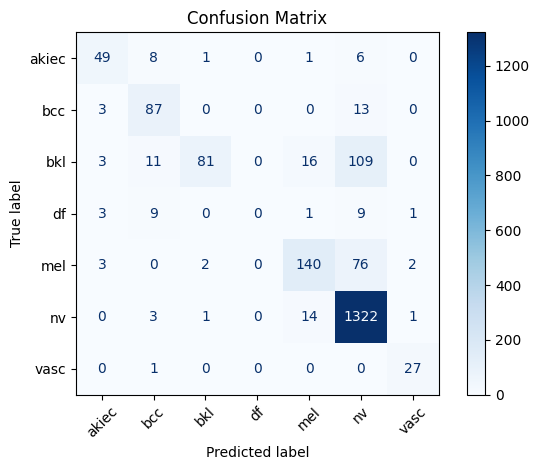

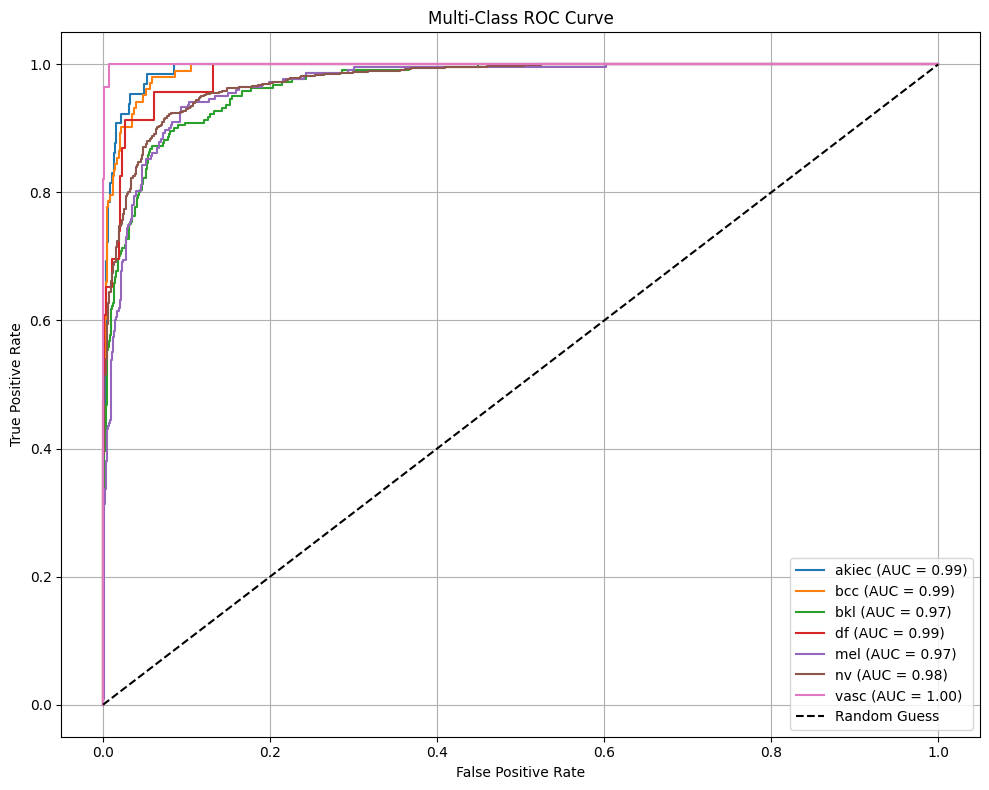

Macro-Averaged AUC: 0.9834


In [14]:
evaluate_model_metrics(student_model, fixed_val_loader, class_names=[
    'akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'
])
